Creating new dataset logic.

In [1]:
import json
from glob import glob

import dill
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

import utility as util
import utility.npu
import utility.shu
import utility.doc

from environment import Environment, Scene
from collect.utility.trajectron import node_to_df, scene_to_df, scenes_to_df
from collect.generate.map import CachedMapData
from collect.visualize.trajectron import render_scene_nodes
from collect.visualize.trajectron import render_entire_map

# import sys; print('\n'.join(sys.path))

## Inspect the dataset data structures

In [2]:
search_datasets = False
rootdir = ".."
datadir = "*"
glob(f"{rootdir}/{datadir}/*.pkl") if search_datasets else []

[]

In [3]:
dataset_14 = util.AttrDict(
        path=f"{ rootdir }/carla_dataset_v4-3/v4-3_split1_train_modfm.pkl",
        name="v4-1",
        desc="CARLA 0.9.13 synthesized dataset all maps",
        has_augments=True)

dataset = dataset_14
with open(dataset.path, 'rb') as f:
    eval_env = dill.load(f, encoding='latin1')
eval_scenes = eval_env.scenes
print(f"Dataset {dataset.name} contains {len(eval_scenes)} scenes.")

Dataset v4-1 contains 500 scenes.


In [4]:
search_configs = True
configdir = "../Trajectron-plus-plus/trajectron"
glob(f"{configdir}/*.json") if search_configs else []

['../Trajectron-plus-plus/trajectron/base_distmap.ph8.json',
 '../Trajectron-plus-plus/trajectron/base_distmapV4-1.ph8.json',
 '../Trajectron-plus-plus/trajectron/base_distmapV4-1.K20.ph8.json',
 '../Trajectron-plus-plus/trajectron/base_distmapV4.ph8.json',
 '../Trajectron-plus-plus/trajectron/base_distmap.K10.ph8.json',
 '../Trajectron-plus-plus/trajectron/base_distmap.json',
 '../Trajectron-plus-plus/trajectron/vel_ee.ph8.json',
 '../Trajectron-plus-plus/trajectron/base_dist.json',
 '../Trajectron-plus-plus/trajectron/base_distmapV4-1.K5.ph8.json',
 '../Trajectron-plus-plus/trajectron/linear.json',
 '../Trajectron-plus-plus/trajectron/base_distmap.ph8.mapV4.json',
 '../Trajectron-plus-plus/trajectron/base_distmapV4-1.K15.ph8.json',
 '../Trajectron-plus-plus/trajectron/base_distmapV2.ph8.json',
 '../Trajectron-plus-plus/trajectron/base_distmapV5.ph8.json',
 '../Trajectron-plus-plus/trajectron/base_distmap.K20.ph8.json',
 '../Trajectron-plus-plus/trajectron/base_distmap.K5.ph8.json',
 

In [5]:
config_1 = util.AttrDict(
    path=f"{configdir}/base_distmap.K15.ph8.json"
)

config = config_1
with open(config.path, 'r', encoding='utf-8') as f:
    hyperparams = json.load(f)

In [6]:
# spill dataset metadata 
scene = eval_scenes[0]
node = scene.nodes[0]
df = scene_to_df(scene)
f = lambda x: [*vars(x).keys()]

print("Environment name:", eval_env.name)
for _, scene in zip(range(10), eval_env.scenes):
    print("Scene name:", scene.name)
print()
    
util.doc.results(
    "Environment keys:", f(eval_env),
    "Scene keys:", f(scene),
    "Node keys:", f(node),
    "Data columns:", [*df.columns]
)

Environment name: Town03
Scene name: Town06/ep017/agent4632/frame00004594
Scene name: Town04/ep006/agent2058/frame00006268
Scene name: Town10HD/ep020/agent5719/frame00000803
Scene name: Town06/ep016/agent4444/frame00004362
Scene name: Town04/ep009/agent2786/frame00009439
Scene name: Town04/ep009/agent2780/frame00009439
Scene name: Town06/ep015/agent4230/frame00003800
Scene name: Town06/ep018/agent4835/frame00005486
Scene name: Town06/ep018/agent4835/frame00005156
Scene name: Town07/ep029/agent5634/frame00003956

Environment keys:
['scenes', 'name', 'node_type_list', 'attention_radius', 'NodeType', 'robot_type', 'standardization', 'standardize_param_memo', '_scenes_resample_prop']

Scene keys:
['ego_initx', 'ego_inity', 'x_min', 'y_min', 'x_max', 'y_max', 'x_size', 'y_size', 'patch_box', 'patch_angle', 'canvas_size', 'homography', 'layer_names', 'map', 'timesteps', 'dt', 'name', 'nodes', 'robot', 'temporal_scene_graph', 'frequency_multiplier', 'description', 'aug_func', 'non_aug_scene',

In [7]:
scene = eval_scenes[16]
aug_idx = 5
if dataset.has_augments:
    print( scene.augmented[aug_idx].patch_angle )

None


25 nodes in scene: 999 ego 1115 1097 1096 1090 1072 1071 1064 1073 1048 1060 1019 1027 1029 1009 1043 1046 1039 1102 1041 1004 1101 1091 1055


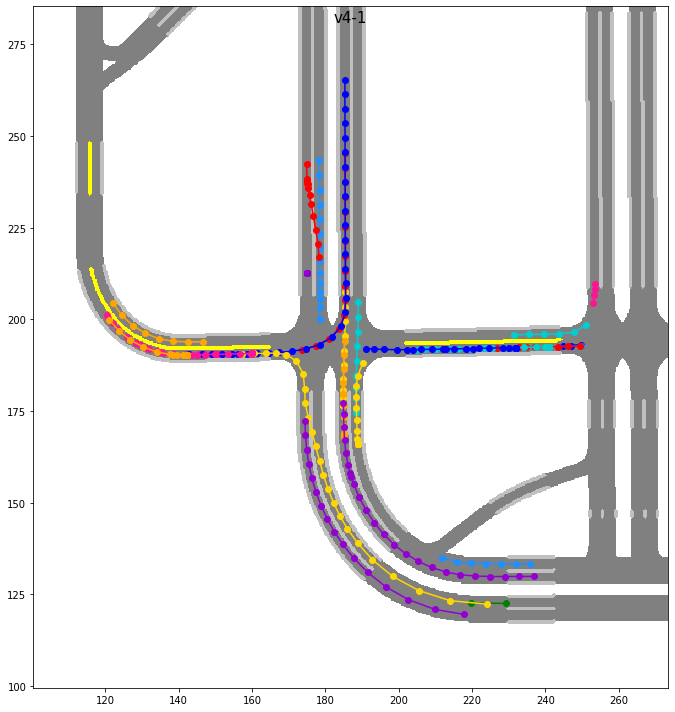

In [8]:
fig, ax = plt.subplots(figsize=(10,10))
node_ids = render_scene_nodes(ax, scene, zoom_in=True)
print(f"{len(node_ids)} nodes in scene: " + ' '.join(node_ids))
fig.tight_layout()
fig.suptitle(dataset.name, fontsize=15)
None

In [9]:
# scene augmentations
aug_idx = 10
aug_scene = scene.augmented[aug_idx]
node = aug_scene.nodes[0]
node.non_aug_node

VEHICLE/999

In [10]:
# map of scene
geomap = scene.map['VEHICLE']
geomap.data.shape, (scene.x_size, scene.y_size)

((3, 1122, 1155), (374, 385))

In [11]:
# inspect environment
env = eval_env
util.doc.results(
    "name", env.name,
    "node_type_list", env.node_type_list,
    "attention_radius", env.attention_radius,
    "robot_type", env.robot_type,
    "standardization", env.standardization,
)

name
Town03

node_type_list
['VEHICLE']

attention_radius
{(VEHICLE, VEHICLE): 30.0}

robot_type
VEHICLE

standardization
{'VEHICLE': {'position': {'x': {'mean': 0, 'std': 80}, 'y': {'mean': 0, 'std': 80}}, 'velocity': {'x': {'mean': 0, 'std': 15}, 'y': {'mean': 0, 'std': 15}, 'norm': {'mean': 0, 'std': 15}}, 'acceleration': {'x': {'mean': 0, 'std': 4}, 'y': {'mean': 0, 'std': 4}, 'norm': {'mean': 0, 'std': 4}}, 'heading': {'x': {'mean': 0, 'std': 1}, 'y': {'mean': 0, 'std': 1}, '°': {'mean': 0, 'std': 3.141592653589793}, 'd°': {'mean': 0, 'std': 1}}}}


In [12]:
# inspect scene
# scene properties
# reference: non_aug_scene is a link from augmented scene to the original ones
util.doc.results(
    "ego_initx", scene.ego_initx,
    "ego_inity", scene.ego_inity,
    "x_min", scene.x_min,
    "y_min", scene.y_min,
    "x_max", scene.x_max,
    "y_max", scene.y_max,
    "x_size", scene.x_size,
    "y_size", scene.y_size,
    "patch_box", scene.patch_box,
    "patch_angle", scene.patch_angle,
    "canvas_size", scene.canvas_size,
    "homography", scene.homography,
    "layer_names", scene.layer_names,
    "timesteps", scene.timesteps,
    "dt", scene.dt,
    "name", scene.name,
    "robot", scene.robot,
    "aug_func", scene.aug_func.__name__,
compact=True, end="", start="scene properties")

util.doc.results(
    "duration", scene.duration(),
compact=True, end="", start="scene computed")

print("First timesteps of nodes")
for node in scene.nodes:
    print(node.first_timestep, end=" ")
print(end="\n\n")

sample_timesteps = scene.sample_timesteps(8, min_future_timesteps=16)
print("Sampled timesteps")
print(sample_timesteps)


scene properties
ego_initx -78.07401275634766
ego_inity -150.3542022705078
x_min -263
y_min -327
x_max 111
y_max 58
x_size 374
y_size 385
patch_box (-76.0, -134.5, 385, 374)
patch_angle 0
canvas_size (1155, 1122)
homography [[3. 0. 0.]
 [0. 3. 0.]
 [0. 0. 3.]]
layer_names ['drivable_area']
timesteps 32
dt 0.5
name Town03/ep000/agent998/frame00002240
robot VEHICLE/ego
aug_func augment

scene computed
duration 16.0

First timesteps of nodes
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 16 18 19 26 28 

Sampled timesteps
[ 3 12 15 13  9  0  4  1]


In [13]:
# inspect node of scene
node = scene.nodes[12]
# node properties
# unused: (length, width, height, description)
# reference: non_aug_node is a link from augmented nodes to the original ones
util.doc.results(
    "type", node.type,
    "id", node.id,
    "first_timestep", node.first_timestep,
    "is_robot", node.is_robot,
    "frequency_multiplier", node.frequency_multiplier,
compact=True, end="", start="node properties")

util.doc.results(
    "timesteps", node.timesteps,
    "last_timestep", node.last_timestep,
compact=True, start="node computed")

node properties
type VEHICLE
id 1019
first_timestep 0
is_robot False
frequency_multiplier 1

node computed
timesteps 8
last_timestep 7


In [14]:
# inspect numpy data from node of scene
node = scene.nodes[11]
query1 = node.data[:, {"position": ("x", "y",), "heading": ("°",)}]
query2 = node.data[:, [("position", "x"), ("position", "y",), ("heading", "°")]]
util.doc.results(
    "position x elem 0:5", node.data[:5, ("position", "x")],
    "position x shape", node.data[:, ("position", "x")].shape,
    "position (x, y) shape", node.data[:, {"position": ("x", "y")}].shape,
    "position (x, y), heading (°,)  shape", query1.shape,
    "two ways of querying are equivalent", np.array_equal(query1, query2),
    "headers", node.data.header,
compact=True, end="", start="node's DoubleHeaderNumpyArray data")

util.doc.results(
    "position x shape", node.data.position.x.shape,
    "position x elem 0:5", node.data.position[:5, "x"],
compact=True, start="accessing node's DoubleHeaderNumpyArray data as SingleHeaderNumpyArray")

node's DoubleHeaderNumpyArray data
position x elem 0:5 [174.40953064 174.56489563 174.88890076 175.46897888 176.3243866 ]
position x shape (16,)
position (x, y) shape (16, 2)
position (x, y), heading (°,)  shape (16, 3)
two ways of querying are equivalent True
headers [('position', 'x'), ('position', 'y'), ('velocity', 'x'), ('velocity', 'y'), ('acceleration', 'x'), ('acceleration', 'y'), ('heading', 'x'), ('heading', 'y'), ('heading', '°'), ('heading', 'd°'), ('velocity', 'norm'), ('acceleration', 'norm')]

accessing node's DoubleHeaderNumpyArray data as SingleHeaderNumpyArray
position x shape (16,)
position x elem 0:5 [174.40953064 174.56489563 174.88890076 175.46897888 176.3243866 ]


In [15]:
# Node.get() and Node.scene_ts_to_node_ts()
node = scene.nodes[-3]
for ts in (
    np.array([-1, 10]),
    np.array([11, 20]),
    np.array([21, 33])
):
    position_xy = node.get(ts, {"position": ("x", "y")})
    trans_ts, pad_l, pad_u  = node.scene_ts_to_node_ts(ts)
    util.doc.results(
        "(first_timestep, last_timestep)", (node.first_timestep, node.last_timestep),
        "given timesteps", ts,
        "transformed timesteps", trans_ts,
        "amount to pad (above, below)", (pad_l, pad_u,),
        "position (x, y) \n", position_xy,
    compact=True, end="", start="node data methods")

node data methods
(first_timestep, last_timestep) (19, 31)
given timesteps [-1 10]
transformed timesteps [0 0]
amount to pad (above, below) (20, 0)
position (x, y) 
 [[nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]]

node data methods
(first_timestep, last_timestep) (19, 31)
given timesteps [11 20]
transformed timesteps [0 1]
amount to pad (above, below) (8, 0)
position (x, y) 
 [[         nan          nan]
 [         nan          nan]
 [         nan          nan]
 [         nan          nan]
 [         nan          nan]
 [         nan          nan]
 [         nan          nan]
 [         nan          nan]
 [174.86790466 242.27005768]
 [174.98558044 238.41252136]]

node data methods
(first_timestep, last_timestep) (19, 31)
given timesteps [21 33]
transformed timesteps [ 2 12]
amount to pad (above, below) (0, 2)
position (x, y) 
 [[175.09251404 237.38182068]
 [175.09280396 237.37871552]
 [175.10103607 237

In [16]:
# Scene.present_nodes() gets the nodes that are present in the scene at each of the timesteps.
timesteps = np.array([0, 10, 20, 30])
present_nodes = scene.present_nodes(timesteps)
for ts, nodes in present_nodes.items():
    util.doc.results(
        "timestep", ts,
        "number of nodes", len(nodes),
        "nodes", nodes,
    compact=True, end="", start="Inspect output of Scene.present_nodes()")

Inspect output of Scene.present_nodes()
timestep 0
number of nodes 19
nodes [VEHICLE/999, VEHICLE/ego, VEHICLE/1115, VEHICLE/1097, VEHICLE/1096, VEHICLE/1090, VEHICLE/1072, VEHICLE/1071, VEHICLE/1064, VEHICLE/1073, VEHICLE/1048, VEHICLE/1060, VEHICLE/1019, VEHICLE/1027, VEHICLE/1029, VEHICLE/1009, VEHICLE/1043, VEHICLE/1046, VEHICLE/1039]

Inspect output of Scene.present_nodes()
timestep 10
number of nodes 15
nodes [VEHICLE/ego, VEHICLE/1115, VEHICLE/1097, VEHICLE/1090, VEHICLE/1072, VEHICLE/1071, VEHICLE/1073, VEHICLE/1048, VEHICLE/1060, VEHICLE/1029, VEHICLE/1009, VEHICLE/1043, VEHICLE/1046, VEHICLE/1039, VEHICLE/1102]

Inspect output of Scene.present_nodes()
timestep 20
number of nodes 15
nodes [VEHICLE/ego, VEHICLE/1115, VEHICLE/1097, VEHICLE/1072, VEHICLE/1071, VEHICLE/1073, VEHICLE/1048, VEHICLE/1009, VEHICLE/1043, VEHICLE/1046, VEHICLE/1039, VEHICLE/1102, VEHICLE/1041, VEHICLE/1004, VEHICLE/1101]

Inspect output of Scene.present_nodes()
timestep 30
number of nodes 16
nodes [VEHI

In [17]:
# Scene.get_nodes_clipped_at_time()
node = scene.nodes[4]
timesteps = np.array([1, 4, 5])
query_ts = np.array([0, 6])

# query data
position_heading = node.get(query_ts, {"position": ("x", "y"), "heading": ("°", "d°")})
# get copies of nodes at the given timesteps and with clips within the range the timesteps fall under.
clipped_nodes = scene.get_nodes_clipped_at_time(timesteps, {env.NodeType[0]: {"position": ("x", "y")}})
clipped_node = clipped_nodes[0]
clipped_position_xy = clipped_node.get(query_ts, {"position": ("x", "y")})
try:
    # we didn't select heading data when clipping
    # so it's not present in the clipped node
    clipped_node.get(query_ts, {"position": ("x", "y"), "heading": ("°", "d°")})
except KeyError as e:
    print(e, "OK", end="\n\n")

util.doc.results(
    "given timesteps", timesteps,
    "query time interval", query_ts,
    "node", node,
    "position (x,y) heading (°,d°)", position_heading,
    "clipped node", clipped_node,
    "clipped node time steps", clipped_node.timesteps,
    "clipped node position (x, y)", clipped_position_xy,
)

('heading', '°') OK

given timesteps
[1 4 5]

query time interval
[0 6]

node
VEHICLE/1096

position (x,y) heading (°,d°)
[[ 2.35896416e+02  1.33294144e+02  3.12076647e+00  3.03866680e-02]
 [ 2.31861275e+02  1.33338135e+02  3.13595980e+00  1.67366359e-02]
 [ 2.27842007e+02  1.33358505e+02  3.13750310e+00 -3.83708250e-03]
 [ 2.23804810e+02  1.33382034e+02  3.13212272e+00 -4.98261461e-02]
 [ 2.19784561e+02  1.33544968e+02  3.08767696e+00 -1.38863345e-01]
 [ 2.15786720e+02  1.33979706e+02  2.99325937e+00 -2.32124316e-01]
 [ 2.11872272e+02  1.34902588e+02  2.85555264e+00 -2.75413467e-01]]

clipped node
VEHICLE/1019

clipped node time steps
5

clipped node position (x, y)
[[         nan          nan]
 [142.59079742 193.87025452]
 [138.55657196 194.01147461]
 [134.60760498 194.73834229]
 [130.85700989 196.20471191]
 [127.44282532 198.33650208]
 [         nan          nan]]


In [18]:
# Use Scene.calculate_scene_graph() to create a TemporalSceneGraph

if scene.temporal_scene_graph is None:
    scene.calculate_scene_graph(
        env.attention_radius,
        hyperparams['edge_addition_filter'],
        hyperparams['edge_removal_filter']
    )

util.doc.results(
    "edge_addition_filter hyperparam", hyperparams['edge_addition_filter'],
    "edge_removal_filter hyperparam", hyperparams['edge_removal_filter'],
    "using edge scaling?", hyperparams['dynamic_edges'],
    "# nodes in scene", len(scene.nodes),
    "# edges at timestep 0:", scene.temporal_scene_graph.get_num_edges(t=0),
compact=True, end="", start="hyper-parameters and TemporalSceneGraph")

timestep = 10
scene_graph = scene.temporal_scene_graph.to_scene_graph(
    timestep,
    len(hyperparams['edge_removal_filter']),
    len(hyperparams['edge_addition_filter'])
)
node = scene.nodes[9]

util.doc.results(
    "# edges", scene_graph.get_num_edges(),
    f"neighbors of {node}", scene_graph.get_neighbors(node, env.NodeType[0]),
    # edge scaling is edge modulation in the paper
    f"edge scaling of {node} neighbors", scene_graph.get_edge_scaling(node),
    # we do not use edge weights
    f"edge weights of {node} neighbors", scene_graph.get_edge_weight(node),
compact=True, start=f"SceneGraph at timestep {timestep}")

hyper-parameters and TemporalSceneGraph
edge_addition_filter hyperparam [0.25, 0.5, 0.75, 1]
edge_removal_filter hyperparam [1, 0]
using edge scaling? yes
# nodes in scene 25
# edges at timestep 0: 46

SceneGraph at timestep 10
# edges 28
neighbors of VEHICLE/1073 [VEHICLE/ego VEHICLE/1115 VEHICLE/1097 VEHICLE/1072 VEHICLE/1048
 VEHICLE/1043]
edge scaling of VEHICLE/1073 neighbors [1.   1.   0.75 1.   1.   1.  ]
edge weights of VEHICLE/1073 neighbors [0.05638489 0.0583356  0.03886042 0.0478752  0.05890545 0.05737126]


## Misc

In [3]:
standardization = {
    'VEHICLE': {
        'position': {
            'x': {'mean': 0, 'std': 80},
            'y': {'mean': 0, 'std': 80}
        },
        'velocity': {
            'x': {'mean': 0, 'std': 15},
            'y': {'mean': 0, 'std': 15},
            'norm': {'mean': 0, 'std': 15}
        },
        'acceleration': {
            'x': {'mean': 0, 'std': 4},
            'y': {'mean': 0, 'std': 4},
            'norm': {'mean': 0, 'std': 4}
        },
        'heading': {
            'x': {'mean': 0, 'std': 1},
            'y': {'mean': 0, 'std': 1},
            '°': {'mean': 0, 'std': np.pi},
            'd°': {'mean': 0, 'std': 1}
        }
    }
}

cached_map_data = CachedMapData()
map_data = cached_map_data.map_datum["Town07"]

AttributeError: module 'utility' has no attribute 'shu'

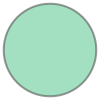

In [14]:
# map_data = cached_map_data.map_datum["Town03"]
# map_data["junctions"][0]
# cached_map_data.map_to_scircles["Town03"][0]

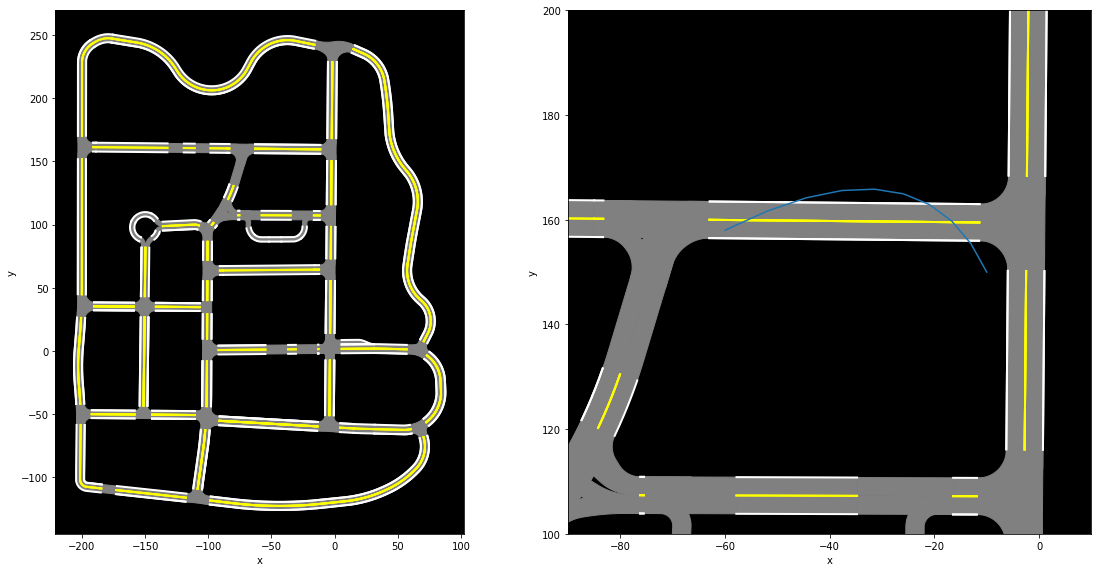

In [41]:
# Construct map data
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(121)
render_entire_map(ax, map_data)

ax = fig.add_subplot(122)
render_entire_map(ax, map_data)
ax.set_xlim([-90, 10])
ax.set_ylim([100, 200])

coords = np.array([
    [-60, 158],
    [-15, 158],
    [-10, 150],
])
points = util.npu.interp_and_sample(coords, 10)
ax.plot(*points.T)

for ax in fig.axes:
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_aspect('equal')
    ax.set_facecolor('black')
fig.tight_layout()

In [40]:

points = np.array([
    [0, 0],
    [1, 1],
    [0, 1],
])





array([[0.        , 0.        ],
       [0.40704398, 0.27971425],
       [0.71232697, 0.51727772],
       [0.91584897, 0.7126904 ],
       [1.01760996, 0.86595229],
       [1.01760996, 0.9770634 ],
       [0.91584897, 1.04602373],
       [0.71232697, 1.07283327],
       [0.40704398, 1.05749203],
       [0.        , 1.        ]])

In [10]:

# create a geometric map

# create a scene

Scene(
    timesteps=,
    map=None, dt=1, name="my_scene", frequency_multiplier=1, aug_func=None,  non_aug_scene=None)

"""NuScenes bitmap format
scene.map[...].as_image() has shape (y, x, c)
Channel 1: lane, road_segment, drivable_area
Channel 2: road_divider
Channel 3: lane_divider
homography: 1m = 3px

An example 
scene.x_size, scene.y_size == (374, 385) has
geomap = scene.map['VEHICLE'].data.shape == (3, 1122, 1155)
"""

# create an environment
env = Environment(
    # nodes present in this environment, primarily VEHICLE and PEDESTRIAN
    node_type_list=['VEHICLE'],
    # specs for normalizing features
    standardization=standardization,
    name="my_environment"
)

attention_radius = dict()
attention_radius[(env.NodeType.VEHICLE, env.NodeType.VEHICLE)] = 30.0
env.attention_radius = attention_radius
env.robot_type = env.NodeType.VEHICLE

In [ ]:
env